## Szkieletyzacja (skeletonization)

Szkieletyzacja polega na stopniowym usuwaniu pikseli z krawędzi obiektu, aż pozostanie jego szkielet — cienka linia biegnąca wzdłuż „środka” obiektu.
Szkielet zachowuje:
* kształt (ogólny zarys),
* topologię (połączenia między częściami),
* długość i układ rozgałęzień.

Piksele z brzegu obiektu są usuwane iteracyjnie, ale tylko wtedy, gdy:
* nie naruszają spójności obiektu,
* nie rozdzielają go na kilka części.

## Pocienianie (thinning)

Pocienianie to proces redukcji szerokości obiektu binarnego do linii o grubości jednego piksela, bez koniecznego zachowania osi symetrii jak w szkieletyzacji.
Działa poprzez stopniowe „ścienianie” kształtu z krawędzi, aż obiekt stanie się maksymalnie cienki.

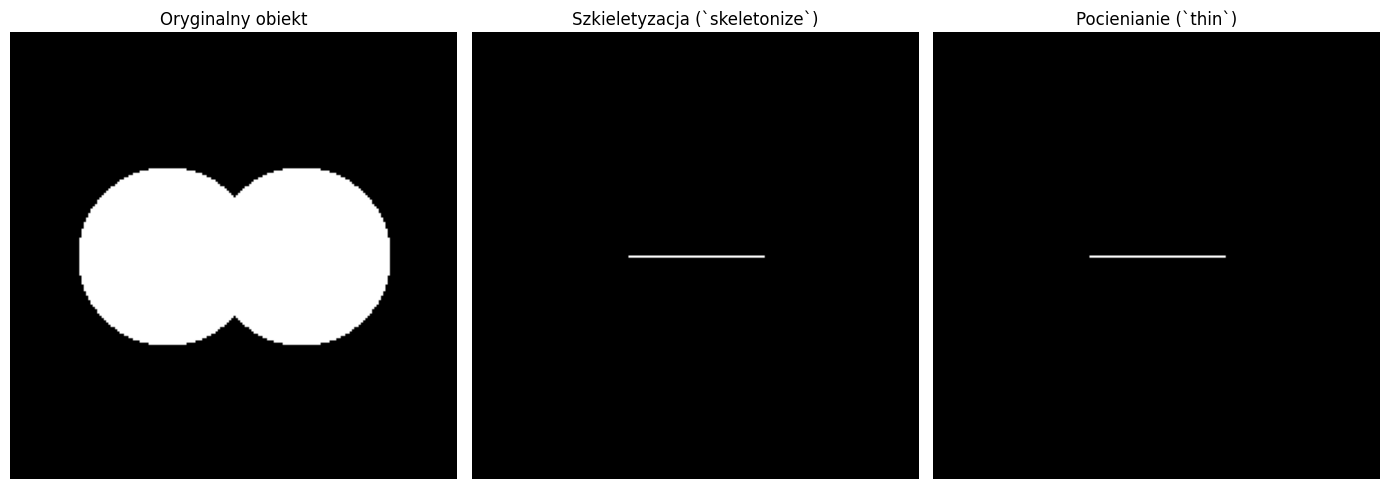

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize, thin
from skimage.draw import disk
from skimage.util import invert

# Utwórz prosty obiekt (np. dwa połączone okręgi)
image = np.zeros((200, 200), dtype=bool)
rr, cc = disk((100, 70), 40)
image[rr, cc] = 1
rr, cc = disk((100, 130), 40)
image[rr, cc] = 1

# Szkieletyzacja i pocienianie
skeleton = skeletonize(image)
thinned = thin(image)

# Wizualizacja
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Oryginalny obiekt")

ax[1].imshow(skeleton, cmap='gray')
ax[1].set_title("Szkieletyzacja (`skeletonize`)")

ax[2].imshow(thinned, cmap='gray')
ax[2].set_title("Pocienianie (`thin`)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

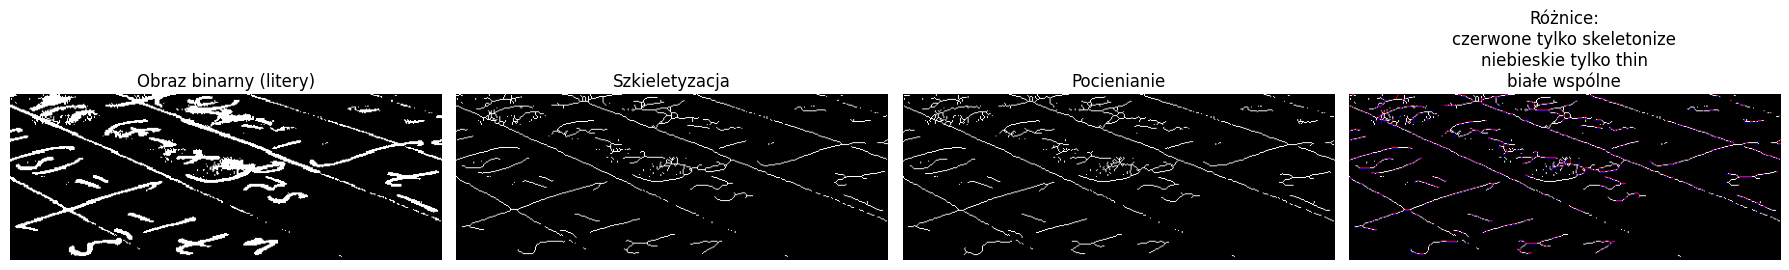

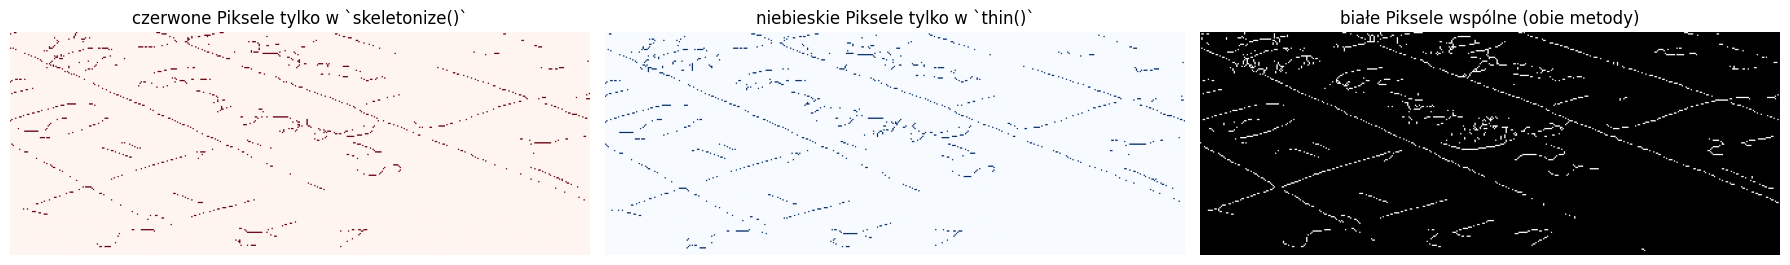

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize, thin

# Wczytaj obraz tekstu
img = data.text()

# Sprawdź czy RGB czy już 2D
if img.ndim == 3:
    gray = color.rgb2gray(img)
else:
    gray = img.astype(np.float64)
    if gray.max() > 1.0:
        gray /= gray.max()

# Binarizacja
th = threshold_otsu(gray)
binary = gray < th
binary = binary.astype(bool)

# Szkieletyzacja i pocienianie
skel = skeletonize(binary)
thin_img = thin(binary)

# Oblicz różnice
only_skel = np.logical_and(skel, np.logical_not(thin_img))   # czerwone
only_thin = np.logical_and(thin_img, np.logical_not(skel))   # niebieskie
both = np.logical_and(skel, thin_img)                        # wspólne (białe)

# Utwórz kolorowy obraz różnic
diff_rgb = np.zeros((*binary.shape, 3))
diff_rgb[..., 0] = only_skel      # red channel
diff_rgb[..., 2] = only_thin      # blue channel
diff_rgb[..., 0:3] += both[..., None]  # dodaj wspólne (biały)

# --- Główne porównanie (4 obrazy) ---
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
ax[0].imshow(binary, cmap='gray')
ax[0].set_title("Obraz binarny (litery)")

ax[1].imshow(skel, cmap='gray')
ax[1].set_title("Szkieletyzacja")

ax[2].imshow(thin_img, cmap='gray')
ax[2].set_title("Pocienianie")

ax[3].imshow(diff_rgb)
ax[3].set_title("Różnice:\nczerwone tylko skeletonize\nniebieskie tylko thin\nbiałe wspólne")

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

# --- Dodatkowe trzy obrazy osobno ---
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(only_skel, cmap='Reds')
ax[0].set_title("czerwone Piksele tylko w `skeletonize()`")

ax[1].imshow(only_thin, cmap='Blues')
ax[1].set_title("niebieskie Piksele tylko w `thin()`")

ax[2].imshow(both, cmap='gray')
ax[2].set_title("białe Piksele wspólne (obie metody)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

* Czerwony - Piksele obecne tylko w skeletonize - Ta metoda zostawia nieco „grubsze” fragmenty i rozgałęzienia.
* Niebieski	- Piksele obecne tylko w thin	Pocienianie usuwa więcej pikseli – daje cieńszy, jednolity szkielet.
* Biały	- Piksele wspólne	To „rdzeń” kształtu – wspólna oś uznana przez obie metody.

## Przycinanie (z ang. Pruning) to proces usuwania krótkich, nieistotnych gałązek ze szkieletu obiektu binarnego.
Celem tej operacji jest oczyszczenie szkieletu z drobnych odgałęzień, które powstały w wyniku:

* szumów w obrazie,
* niejednorodnego oświetlenia,
* nieidealnej segmentacji lub binarizacji.

Metody przycinania

* Iteracyjne usuwanie końcówek - najprostsza metoda: w każdej iteracji usuwa się piksele końcowe (z jednym sąsiadem). Po kilku iteracjach znikają krótkie odnogi, ale główny kształt zostaje zachowany.

* Pruning oparty na długości gałęzi. Wykrywa wszystkie gałęzie i mierzy ich długość (np. przez przeszukiwanie grafu). Usuwa tylko te, których długość < ustalonego progu (np. 10 pikseli).

* Pruning morfologiczny - Wykorzystuje operacje morfologiczne (np. hit-or-miss) do usuwania specyficznych wzorców końcówek.

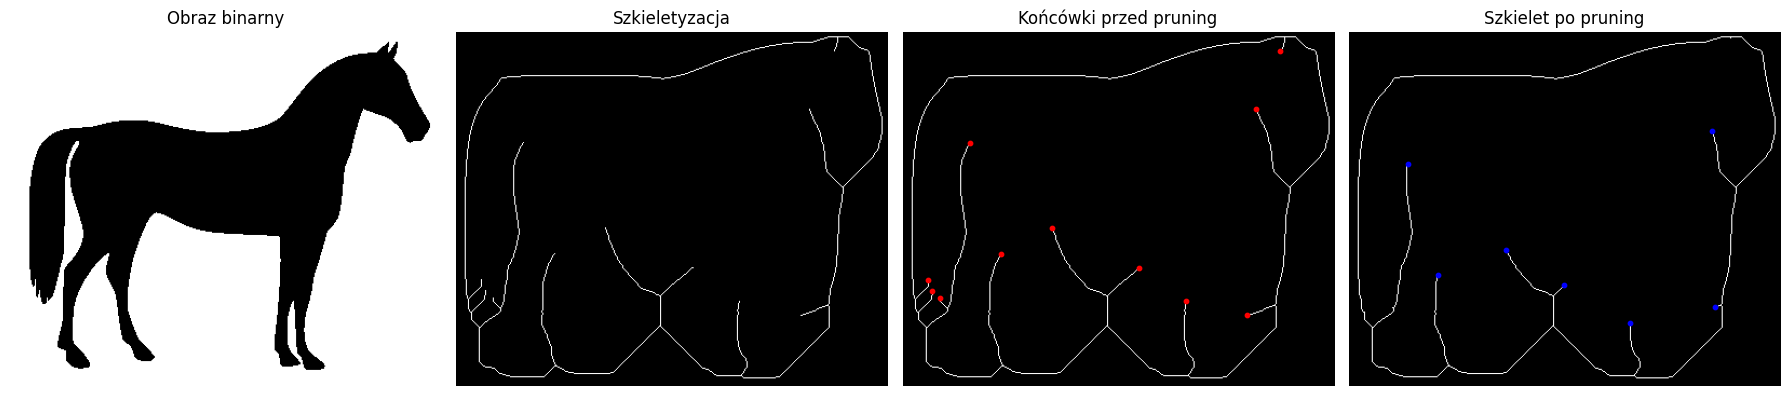

Piksele szkieletu (przed): 1823
Piksele szkieletu (po)   : 1624
Końcówki (przed)         : 11
Końcówki (po)            : 7


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage import data, color
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize, remove_small_objects

# --------- 0) Pomocnicze: bezpieczne przygotowanie obrazu binarnego ---------
def to_binary(img):
    """Zwraca obraz binarny (bool) niezależnie od formatu wejścia."""
    if img.dtype == bool and img.ndim == 2:
        return img
    if img.ndim == 3:   # RGB -> gray
        gray = color.rgb2gray(img)
    else:               # już 2D
        gray = img.astype(float)
        if gray.max() > 1.0:  # unormuj jeśli trzeba
            gray /= gray.max()
    th = threshold_otsu(gray)
    return (gray < th)  # ciemne obiekty = True

# Dane i binarizacja
img = data.horse()              # 2D (często bool)
binary = to_binary(img)
binary = remove_small_objects(binary, 64)

# Szkieletyzacja
skel = skeletonize(binary)

# Końcówki i pruning
def find_endpoints(skel_bool):
    """Zwraca maskę końcówek (pikseli z 1 sąsiadem w 8-sąsiedztwie)."""
    # 10 dla centrum, 1 dla sąsiadów -> 10 + 1 = 11 oznacza końcówkę
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    conv = convolve(skel_bool.astype(np.uint8), kernel, mode='constant', cval=0)
    return conv == 11

def prune_skeleton(skel_bool, max_len=15):
    """
    Iteracyjnie usuwa końcówki do zadanej długości gałązki (max_len w pikselach).
    Każda iteracja odcina 1 piksel na końcu gałęzi.
    """
    pruned = skel_bool.copy()
    for _ in range(max_len):
        endpoints = find_endpoints(pruned)
        # zatrzymaj, gdy nie ma już krótkich końcówek
        if not endpoints.any():
            break
        pruned = np.logical_and(pruned, ~endpoints)
    return pruned

pruned = prune_skeleton(skel, max_len=20)

# Wizualizacja: oryginał, szkielet, końcówki, pruning
endpoints_before = find_endpoints(skel)
endpoints_after  = find_endpoints(pruned)

fig, ax = plt.subplots(1, 4, figsize=(18, 5))
ax[0].imshow(binary, cmap='gray'); ax[0].set_title("Obraz binarny"); ax[0].axis('off')
ax[1].imshow(skel, cmap='gray');   ax[1].set_title("Szkieletyzacja"); ax[1].axis('off')

# nałóż końcówki przed pruning (czerwone)
ax[2].imshow(skel, cmap='gray')
y, x = np.where(endpoints_before)
ax[2].scatter(x, y, s=10, c='r')
ax[2].set_title("Końcówki przed pruning"); ax[2].axis('off')

# szkielet po pruning + końcówki po (niebieskie)
ax[3].imshow(pruned, cmap='gray')
y2, x2 = np.where(endpoints_after)
ax[3].scatter(x2, y2, s=10, c='b')
ax[3].set_title("Szkielet po pruning"); ax[3].axis('off')

plt.tight_layout()
plt.show()

# Prosta statystyka
print("Piksele szkieletu (przed):", int(skel.sum()))
print("Piksele szkieletu (po)   :", int(pruned.sum()))
print("Końcówki (przed)         :", int(endpoints_before.sum()))
print("Końcówki (po)            :", int(endpoints_after.sum()))

# Zadanie 1. Analiza układu naczyń krwionośnych (lub dróg) z wykorzystaniem szkieletyzacji

Cel:
Zastosować szkieletyzację do analizy i modelowania rozgałęzionej struktury obiektów — takich jak naczynia krwionośne, korzenie roślin, sieci drogowe lub linie pisma.
Celem jest uzyskanie uproszczonej reprezentacji struktury (szkieletu), która zachowuje topologię, umożliwia pomiar długości i rozgałęzień.

Wyobraź sobie, że jesteś inżynierem biomedycznym analizującym zdjęcia mikroskopowe naczyń krwionośnych. Obraz jest binarny (ciemne naczynia na jasnym tle). Chcesz automatycznie:

* uzyskać szkielet naczyń,
* obliczyć łączną długość naczyń,
* określić liczbę rozgałęzień i końcówek.

Podobne podejście można wykorzystać np. w analizie:

* sieci dróg z obrazów satelitarnych,
* struktur roślinnych (korzeni, liści),
* połączeń ścieżek w układach scalonych.


# Kolejne kroki

Wczytaj obraz (np. mikroskopowy obraz naczyń lub sieć dróg — można użyć data.retina() lub własnego zdjęcia).
Jeśli obraz jest kolorowy — przekształć go do skali szarości.

1. Wykonaj progowanie (np. metodą Otsu), aby uzyskać obraz binarny przedstawiający strukturę obiektu.

2. Wyczyść obraz – usuń małe obiekty i zakłócenia (remove_small_objects, closing, opening).

3. Zastosuj szkieletyzację (skeletonize) do uzyskania osi struktur.

4. Oblicz cechy geometryczne:

* liczbę końcówek szkieletu (punkty z jednym sąsiadem),
* liczbę rozgałęzień (punkty z więcej niż dwoma sąsiadami).

Koncepcja cech geometrycznych szkieletu:
Każdy piksel w szkielecie ma pewną liczbę sąsiadów (8-sąsiedztwo):
* Końcówka (endpoint): piksel, który ma dokładnie jednego sąsiada.
→ Jest to koniec gałęzi szkieletu.
* Rozgałęzienie (branch point): piksel, który ma więcej niż dwóch sąsiadów.→ W tym miejscu łączą się lub rozdzielają gałęzie struktury.

Wizualizuj wynik:

* oryginalny obraz,
* obraz binarny,
* szkielet

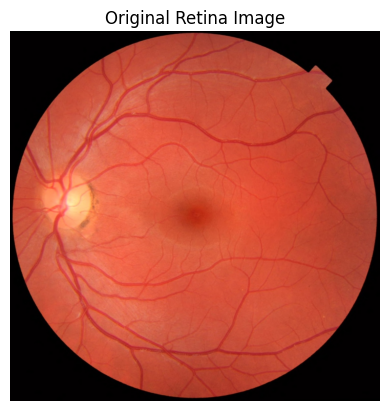

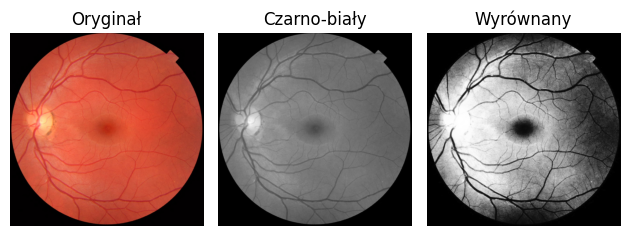

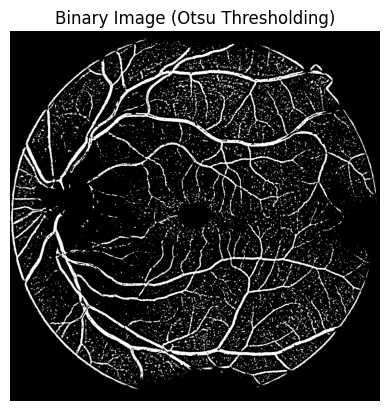

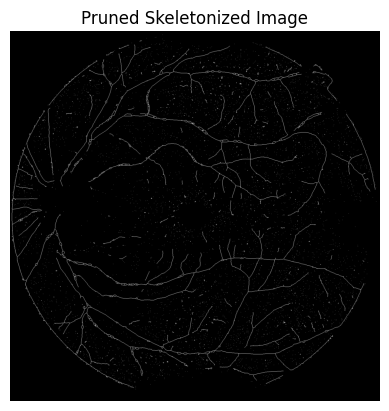

Liczba końcówek (endpoints): 141
Liczba rozgałęzień (branch points): 4433
Łączna długość naczyń (w pikselach): 29389


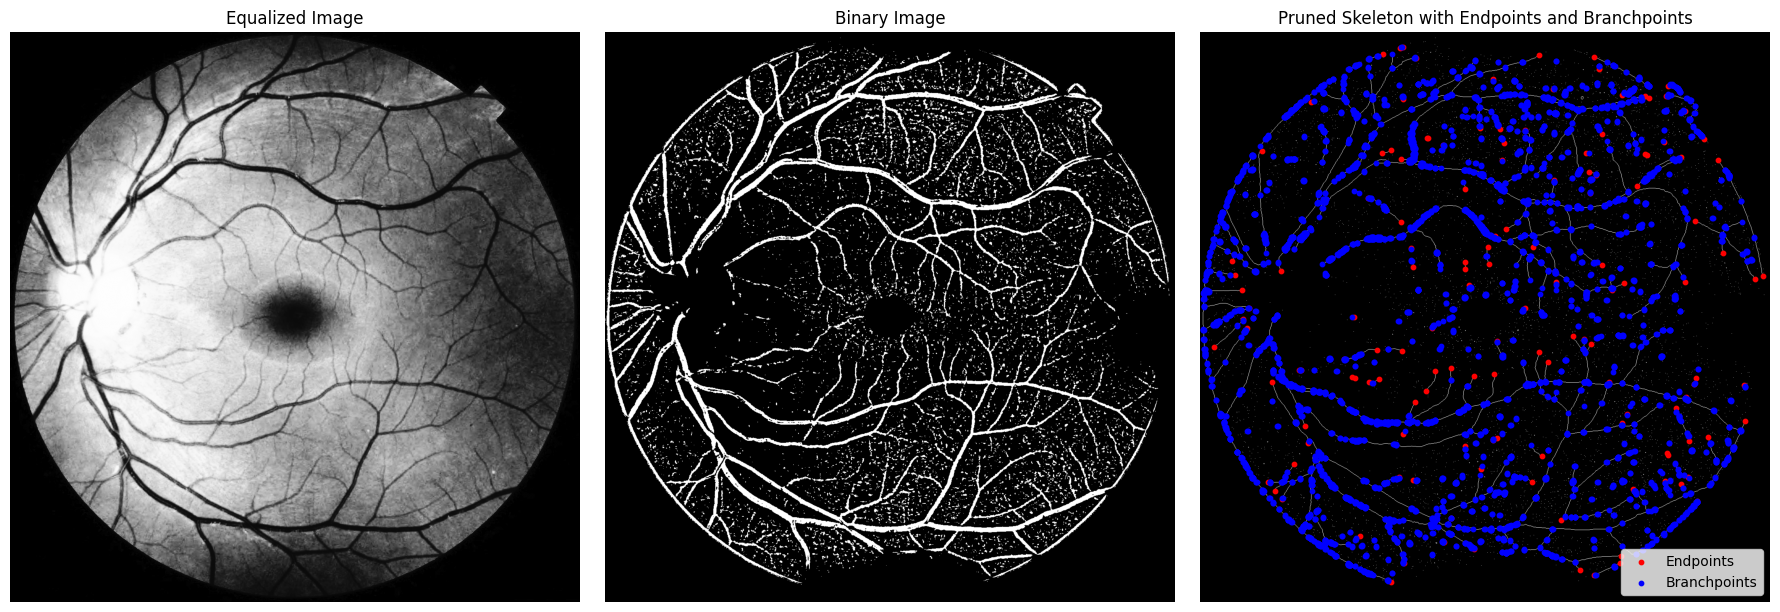


=== Wnioski ===
Szkieletyzacja pozwala na uproszczoną reprezentację struktury naczyń krwionośnych.
Wykryto 141 końcówek i 4433 rozgałęzień.
Łączna długość naczyń wynosi 29389 pikseli.
To umożliwia analizę topologii sieci naczyń, np. w diagnostyce chorób oczu.


In [23]:
# Zadanie 1: Analiza układu naczyń krwionośnych z wykorzystaniem szkieletyzacji

# Importy potrzebne dla zadania
from skimage import data, filters, morphology, measure
from skimage.morphology import skeletonize
from scipy import ndimage
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import threshold_local
from skimage.exposure import equalize_hist

def show_row(images, titles=None, cmap=None):
    """
    Wyświetla kilka obrazów obok siebie w jednym wierszu.

    Parametry:
    -----------
    images : list
        Lista obrazów (tablic NumPy) do wyświetlenia.
    titles : list (opcjonalnie)
        Lista tytułów dla każdego obrazu.
    cmap : str (opcjonalnie)
        Mapa kolorów (np. 'gray' dla obrazów w skali szarości).
    """

    n = len(images)                          # Liczba obrazów
    fig, axes = plt.subplots(1, n)           # Tworzy jeden wiersz z n kolumnami (dla każdego obrazu jedna oś)

    # Iteracja po wszystkich obrazach i ich osiach
    for i, ax in enumerate(np.atleast_1d(axes)):
        ax.imshow(images[i], cmap=cmap[i])      # Wyświetla obraz (z opcjonalną mapą kolorów)
        ax.axis('off')                       # Ukrywa osie (ramki, skale, liczby)
        if titles:                           # Jeśli podano tytuły
            ax.set_title(titles[i])          # Ustawia tytuł nad obrazem

    plt.tight_layout()
    plt.show()

# 1. Wczytaj obraz (mikroskopowy obraz naczyń krwionośnych)
image = data.retina()  # Obraz siatkówki z naczyniami krwionośnymi

# Wyświetl oryginalny obraz
plt.imshow(image, cmap='gray')
plt.title("Original Retina Image")
plt.axis('off')
plt.show()

img = data.retina()
gray_img = rgb2gray(img)
eq_img = equalize_hist(gray_img)


show_row(
    [img, gray_img, eq_img],
    ["Oryginał", "Czarno-biały", "Wyrównany"],
    ['brg', 'gray', 'gray']
)

gray_img = rgb2gray(img)
eq_img = equalize_hist(gray_img)
eq_img = (eq_img * 255).astype(np.uint8)

# 2. Wykonaj progowanie metodą Otsu
from skimage.filters import threshold_local
block_size = 35
thresh = threshold_local(eq_img, block_size, offset=10)
binary = eq_img < thresh

plt.imshow(binary, cmap='gray')
plt.title("Binary Image (Otsu Thresholding)")
plt.axis('off')
plt.show()

# 3. Wyczyść obraz – usuń małe obiekty i zakłócenia
cleaned = binary

# 4. Zastosuj szkieletyzację
skeleton = skeletonize(cleaned)

# Dodaj funkcje pomocnicze dla wykrywania końcówek i rozgałęzień
def find_endpoints(skel_bool):
    """Zwraca maskę końcówek (pikseli z 1 sąsiadem w 8-sąsiedztwie)."""
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    conv = ndimage.convolve(skel_bool.astype(np.uint8), kernel, mode='constant', cval=0)
    return conv == 11

def find_branchpoints(skel_bool):
    """Zwraca maskę rozgałęzień (pikseli z 3+ sąsiadami w 8-sąsiedztwie)."""
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    conv = ndimage.convolve(skel_bool.astype(np.uint8), kernel, mode='constant', cval=0)
    return conv >= 13

def prune_skeleton(skel_bool, max_len=10):
    """
    Iteracyjnie usuwa końcówki do zadanej długości gałązki (max_len w pikselach).
    """
    pruned = skel_bool.copy()
    for _ in range(max_len):
        endpoints = find_endpoints(pruned)
        if not endpoints.any():
            break
        pruned = np.logical_and(pruned, ~endpoints)
    return pruned

# Zastosuj pruning do oczyszczenia szkieletu
pruned_skeleton = prune_skeleton(skeleton, max_len=15)

plt.imshow(pruned_skeleton, cmap='gray')
plt.title("Pruned Skeletonized Image")
plt.axis('off')
plt.show()

# 5. Oblicz cechy geometryczne szkieletu
endpoints_mask = find_endpoints(pruned_skeleton)
branchpoints_mask = find_branchpoints(pruned_skeleton)

num_endpoints = int(endpoints_mask.sum())
num_branchpoints = int(branchpoints_mask.sum())

print(f"Liczba końcówek (endpoints): {num_endpoints}")
print(f"Liczba rozgałęzień (branch points): {num_branchpoints}")

# Oblicz łączną długość naczyń (liczba pikseli w szkielecie)
total_length = np.sum(pruned_skeleton)
print(f"Łączna długość naczyń (w pikselach): {total_length}")

# 6. Wizualizacja wyników
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Oryginalny obraz
axes[0].imshow(eq_img, cmap='gray')
axes[0].set_title("Equalized Image")
axes[0].axis('off')

# Obraz binarny
axes[1].imshow(cleaned, cmap='gray')
axes[1].set_title("Binary Image")
axes[1].axis('off')

# Szkielet z zaznaczonymi punktami
axes[2].imshow(pruned_skeleton, cmap='gray')
axes[2].set_title("Pruned Skeleton with Endpoints and Branchpoints")
axes[2].axis('off')

# Zaznacz końcówki (czerwone)
ep_y, ep_x = np.where(endpoints_mask)
axes[2].scatter(ep_x, ep_y, c='red', s=10, label='Endpoints')

# Zaznacz rozgałęzienia (niebieskie)
bp_y, bp_x = np.where(branchpoints_mask)
axes[2].scatter(bp_x, bp_y, c='blue', s=10, label='Branchpoints')

axes[2].legend()

plt.tight_layout()
plt.show()

# Wnioski
print("\n=== Wnioski ===")
print("Szkieletyzacja pozwala na uproszczoną reprezentację struktury naczyń krwionośnych.")
print(f"Wykryto {num_endpoints} końcówek i {num_branchpoints} rozgałęzień.")
print(f"Łączna długość naczyń wynosi {total_length} pikseli.")
print("To umożliwia analizę topologii sieci naczyń, np. w diagnostyce chorób oczu.")

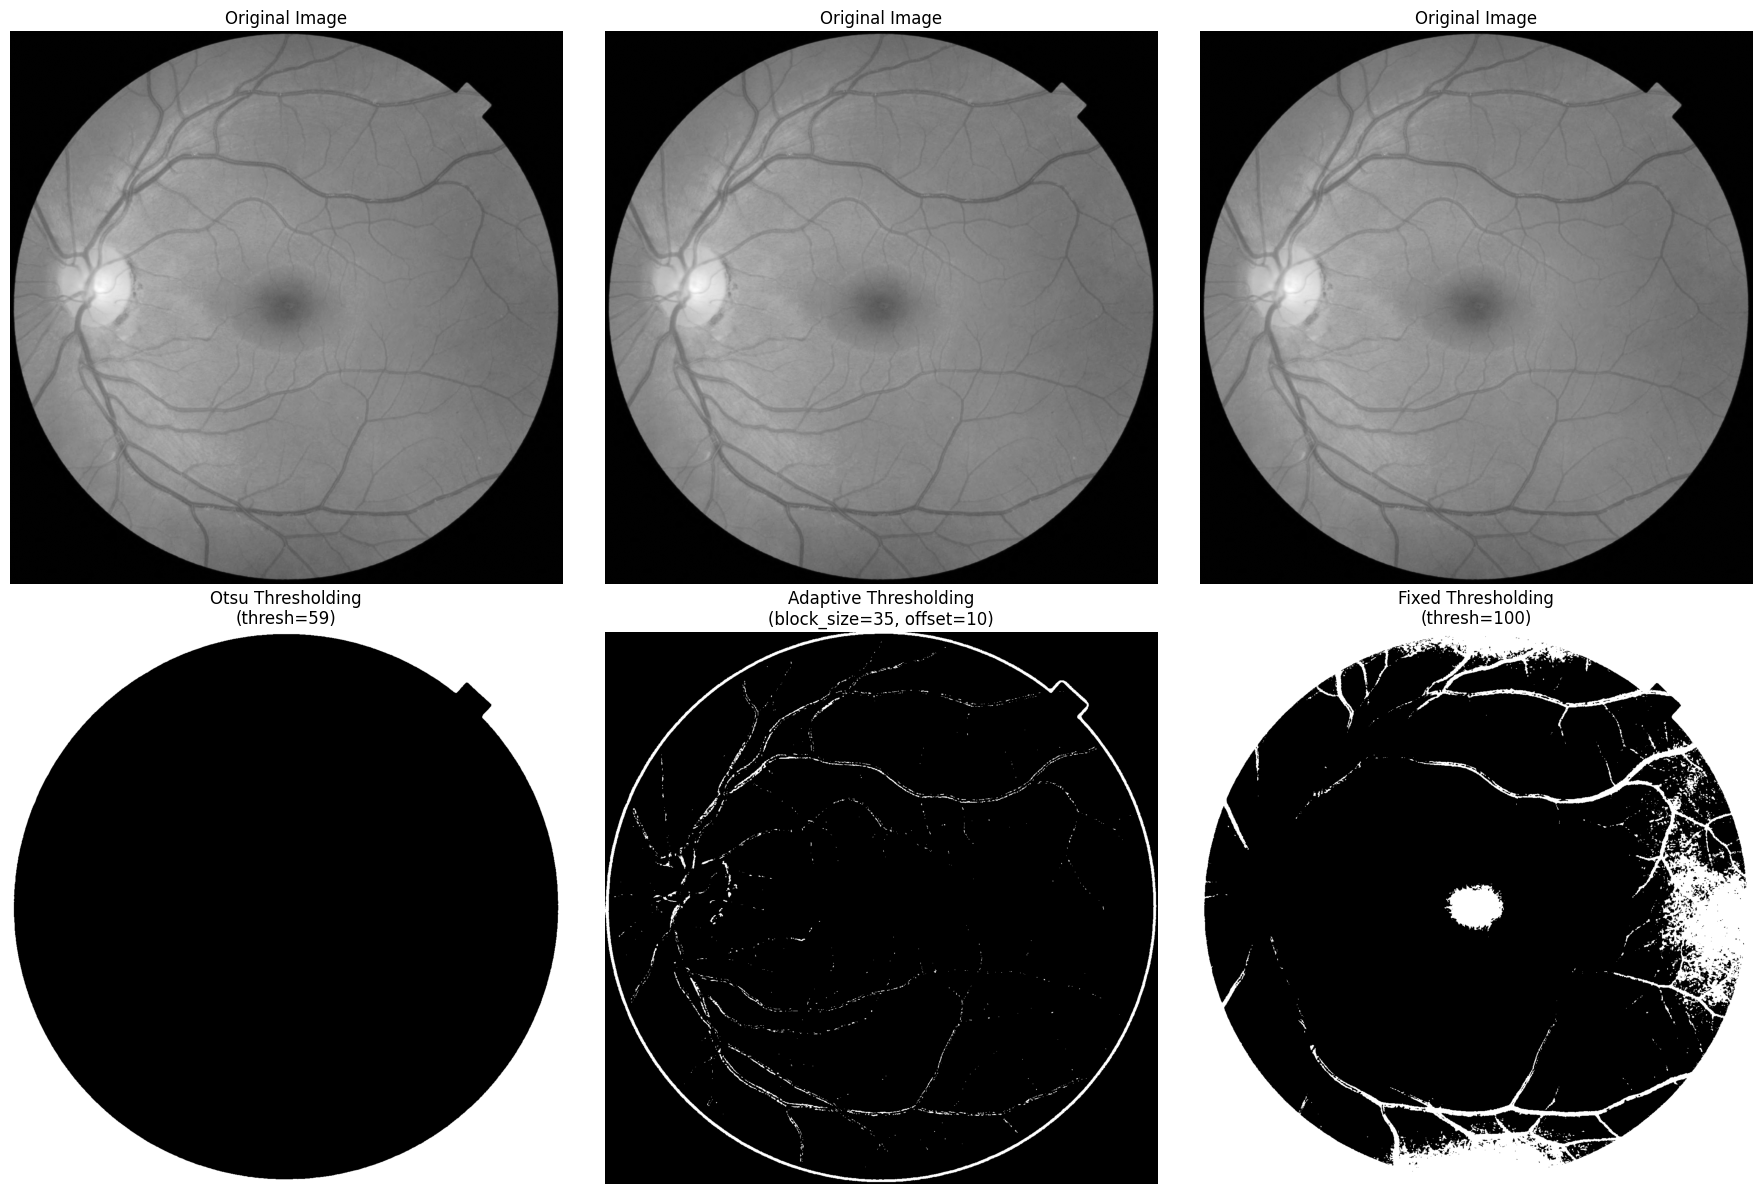

Liczba pikseli naczyń:
Otsu: 469731
Adaptive: 52344
Fixed: 654758


In [16]:
# Przykłady różnych metod binaryzacji na obrazie siatkówki

import matplotlib.pyplot as plt
import numpy as np
from skimage import data, filters
from skimage.filters import threshold_local

# Wczytaj obraz
image = data.retina()
if image.ndim == 3:
    image_gray = np.mean(image, axis=2).astype(np.uint8)
else:
    image_gray = image

# Metoda 1: Progowanie Otsu
thresh_otsu = filters.threshold_otsu(image_gray)
binary_otsu = image_gray < thresh_otsu

# Metoda 2: Progowanie adaptacyjne (lokalne)
block_size = 35
thresh_adaptive = threshold_local(image_gray, block_size, offset=10)
binary_adaptive = image_gray < thresh_adaptive

# Metoda 3: Progowanie stałe (fixed threshold)
fixed_thresh = 100  # przykładowa wartość
binary_fixed = image_gray < fixed_thresh

# Wizualizacja trzech metod
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Oryginalny obraz
axes[0, 0].imshow(image_gray, cmap='gray')
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(image_gray, cmap='gray')
axes[0, 1].set_title("Original Image")
axes[0, 1].axis('off')

axes[0, 2].imshow(image_gray, cmap='gray')
axes[0, 2].set_title("Original Image")
axes[0, 2].axis('off')

# Binary images
axes[1, 0].imshow(binary_otsu, cmap='gray')
axes[1, 0].set_title(f"Otsu Thresholding\n(thresh={thresh_otsu})")
axes[1, 0].axis('off')

axes[1, 1].imshow(binary_adaptive, cmap='gray')
axes[1, 1].set_title("Adaptive Thresholding\n(block_size=35, offset=10)")
axes[1, 1].axis('off')

axes[1, 2].imshow(binary_fixed, cmap='gray')
axes[1, 2].set_title(f"Fixed Thresholding\n(thresh={fixed_thresh})")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Porównanie liczby wykrytych pikseli naczyń
print("Liczba pikseli naczyń:")
print(f"Otsu: {binary_otsu.sum()}")
print(f"Adaptive: {binary_adaptive.sum()}")
print(f"Fixed: {binary_fixed.sum()}")